# Managing 2017 Data

This process is just about the same as [2013 Data](jn_1_2013_data.ipynb). I will make different decisions when vectorizing and modeling based on the 2017 data.

I want to look at titles from both subreddits from the year 2017. There are a few things that I had to adjust before modeling and interpreting my data.

1. For every year of each subreddit, `mildlyinteresting` has a multitude of more posts than `mildlyinfuriating`. That results in unbalanced classes when I model. My solution to that is: I will use all of my 2013 data collected from `mildlyinfuriating` but I will keep track of how many files there are (each file consists of 1000 posts - see [scrape.py](./scrape.py)). I will then randomly sample that many files from all of files I have from `mildlyinteresting` of that same year. This ensures that I have balanced classes when I model.
2. From my EDA, I've seen that the words `interesting` and `infuriating` were some of the most impactful words (both were the 2nd highest respectively). I will include them amongst my `stop_words`. Also, I noticed at least two words who's base and adverb were among the top 15 strongest words. Because of that, I planned to lemmatize my corpus (see cell [class LemToken()](#lem_token) in [2013 Data](jn_1_2013_data.ipynb), since doing so will provide me with more accurate results. However, I realized that its very computationally expensive, and since it most likely won't interfere with my top results, I can skip this step.

## Setup:
1. Bring in all needed 2017 JSON data from both subreddits. I will use this as train data. As well as bring in the first 1000 posts of both subreddit from 2018. I will use this as test data.
2. I will model this data in a number of ways and tune them to get the best results.
3. Visualize certain features. I will usually look at the strongest words, and if there's a high score, I will also compare true to predicted.
4. Address **Tasks 2-4**

In [68]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import word_tokenize
from sklearn import metrics
from glob import glob
import pandas as pd
import numpy as np
import regex as r
import random
import pickle
import json

%matplotlib inline

## Step 1
Here's the first difference. `MildlyInfuriating` has nearly 76,000 posts whereas `mildlyinteresting` has 255,000 posts for only the year 2017. Contrast that to the 15,000 `mildlyInfuriating` posts from 2013. Because of that, I only randomly sampled 15,000 posts from `mildlyinteresting`. Due to limited computational power, I will do the same thing, and randomly sample only 10,000 post titles from each subreddit for 2017.

In [3]:
# Limit to only 10 mildlyinfuriating files for 2017
all_train = []
for f_name in random.sample(glob('../data/mildlyinteresting/2017/*.json'), 10):
    with open(str(f_name)) as f:
        all_train += json.load(f)['data']
for f_name in random.sample(glob('../data/mildlyinfuriating/2017/*.json'), 10):
    with open(str(f_name)) as f:
        all_train += json.load(f)['data']

In [4]:
all_test = []
with open('../data/mildlyinteresting/2018/data_1514765920.json') as f:
    all_test += json.load(f)['data']
with open('../data/mildlyinfuriating/2018/data_1514139423.json') as f:
    all_test += json.load(f)['data']

In [5]:
df_train = pd.DataFrame(data=all_train, columns=['title','subreddit'])
df_test = pd.DataFrame(data=all_test, columns=['title','subreddit'])

In [6]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [70]:
df_train.to_csv('../assets/train_2017', sep='\t', encoding='utf-8')
df_test.to_csv('../assets/test_2017', sep='\t', encoding='utf-8')

In [7]:
X_train = df_train['title']
y_train = pd.get_dummies(df_train['subreddit'],drop_first=True)
X_test = df_test['title']
y_test = pd.get_dummies(df_test['subreddit'],drop_first=True)
subreddits = ['mildlyinteresting','mildlyinfuriating']

**Making sure my classes are balanced:**

In [8]:
y_train.sum()/y_train.shape[0]

mildlyinteresting    0.503888
dtype: float64

In [38]:
sw = stopwords.words('english') + ['interesting','infuriating','grew','looked','trees','tiles','fuck']

**The words 'grew', 'looked', 'trees', 'tiles',and 'fuck' have been dropped since I couldn't lemmatize due to computational reasons, and they are in the top 15. Also, my following `TfidfVectorizer` and `LogisticRegression` have been previously optimized using GridSearchCV.**

In [47]:
tfidf = TfidfVectorizer(
                        min_df=1,
                        max_df=1.0,
                        stop_words=sw,
                        analyzer='word',
                        max_features=800,
                        token_pattern=r'\w{1,}',
                        strip_accents='unicode')

In [48]:
train_tf = tfidf.fit_transform(X_train,y_train)
test_tf = tfidf.transform(X_test)

## Step 2

In [49]:
lr = LogisticRegression(C=.999, max_iter=100, solver='saga', random_state=42)

In [50]:
lr.fit(train_tf, y_train.values.ravel())
y_pred = lr.predict(test_tf)
y_pred_prob = lr.predict_proba(test_tf)[:, 1]

In [51]:
print('Train data score: {} \nTest data score: {}'.format(lr.score(train_tf,y_train),lr.score(test_tf,y_test)))

Train data score: 0.7308259212198221 
Test data score: 0.7012072434607646


** This is good to see. My model isn't overfit to the train data.**

In [52]:
coefs_df = pd.DataFrame({"Feature":tfidf.get_feature_names(),"Weight":lr.coef_[0],"Positive":lr.coef_[0] > 0})
# 'Positive' here refers to the numeric value. 

In [56]:
coefs_df.sort_values('Weight',ascending=False).head()

,Feature,Weight,Positive
408,looks,5.979665,True
722,tree,3.571327,True
267,found,3.281012,True
610,shaped,3.136430,True
81,bird,3.115747,True


In [57]:
coefs_df.sort_values('Weight').head()

,Feature,Weight,Positive
131,centered,-3.183929,False
706,tile,-2.831528,False
275,fucking,-2.790336,False
224,every,-2.559091,False
174,crooked,-2.417391,False


In [55]:
def bar_plot_features(coefs_df, post_weight, neg_weight,xt_1, xt_2, axh):
    a = coefs_df[(coefs_df['Weight'] >= post_weight) | (coefs_df['Weight'] <= neg_weight)].sort_values('Weight')['Weight']
    b = coefs_df[(coefs_df['Weight'] >= post_weight) | (coefs_df['Weight'] <= neg_weight)].sort_values('Weight')['Feature']

    N = len(a)
    ind = np.arange(N)
    width= .5

    plt.barh(ind, a, width) #, color=coefs_df['Positive'].map({True: 'orange', False: 'purple'})
                            # doing this somehow still displays wrong colors.

    plt.xlabel('Word Strength',fontsize=20)
    plt.title('Strongest Words for Infuritation & Interest',fontsize=35)
    plt.yticks(ind, b,fontsize=20, rotation=0)

    plt.xticks(np.arange(xt_1, xt_2, .5),fontsize=11)

    plt.axvline(x=0.0, c='black')
    plt.axhline(y=axh, c='black', linestyle='--')

    a = plt.gcf()
    a.set_size_inches(17, 9)

    plt.show()

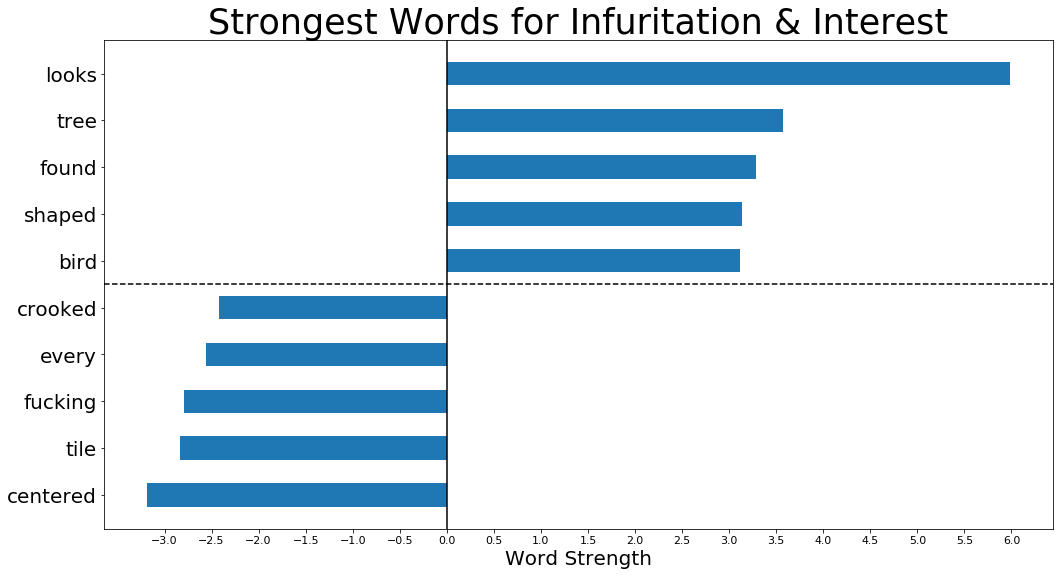

In [61]:
bar_plot_features(coefs_df, 3.115747, -2.417391, -3.0, 6.5, 4.5)

**It's nice to always be able to visualize how impactful these words are in respect to one another. For example, in regrads to the `infuriating` words, they all gradually get more strength, but when it comes to `interesting`, there's a huge jump from "tree" to "looks".**

## Step 2 (finding better models)

Since I now know my data is very similar to my 2013 data, I can use the best models I found for accuracy there, and apply them here. I will tune for hyperparameters as needed.

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [66]:
bag = BaggingClassifier(random_state=3,n_jobs=3)
bag_params = {
    'n_estimators': [100, 30, 170],
    'base_estimator': [DecisionTreeClassifier(random_state=3),KNeighborsClassifier()]
}
gs_bag = GridSearchCV(bag,param_grid=bag_params,cv=3,verbose=1)
gs_bag.fit(train_tf,y_train.values.ravel())
gs_bag.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 46.3min finished


0.6836086404066074

In [69]:
with open('../assets/bag_2017_tuned_pipe.pkl', 'wb+') as f:
    pickle.dump(gs_bag, f)

In [71]:
gs_bag.best_params_

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=3,
             splitter='best'), 'n_estimators': 170}

In [72]:
acc_bag = metrics.accuracy_score(y_test.values.ravel(),gs_bag.best_estimator_.predict(test_tf))
acc_bag

0.6780684104627767

In [74]:
acc_lr = metrics.accuracy_score(y_test.values.ravel(),y_pred)
acc_lr

0.7012072434607646

In [75]:
coefs_df.to_csv('../assets/coefs_lr_2017', sep='\t', encoding='utf-8')

## Step 3
There isn't much of a step 3 after running a `BaggingClassifier`. After my results from the [2013 Data](jn_1_2013_data.ipynb), I assumed that `LogisticRegression` would again have a higher accuracy score, and would provide feature importances from which inferences could be drawn.

# Task 2
(from [Notebook 0](jn_0_gather_data_and_eda.ipynb))

1. It's clear that `LogisitcRegression` scored better with around 70% whereas a tuned `BaggingClassifier` scored a max of around 68%. (Also realize that the latter model requires much more computation.)
2. `LogisitcRegression` clearly describes which features impact which subreddit, which is great.

### Goal:
I wanted to be able to use this data personally advertise on `mildlyinteresting` and trash talk my competitors on `mildlyinfuriating` and I think I have the results to do so. Looking at the bar graph above, in 2017, I could promote my product by referring to by "discovering" it, or somehow associating it to nature. Focusing on I 'found' or the product 'looks' like, or even while you all see cool new trees and birds, I 'found' this product. On the other hand, I demote my competitors, I can mention how 'every' time, that product is 'fucking' 'crooked' and isn't 'centered'.

# Task 3
(from [Notebook 0](jn_0_gather_data_and_eda.ipynb))

In [90]:
coef_df_2013 = pd.read_csv('../assets/coefs_lr_2013',sep='\t').drop('Unnamed: 0',axis=1)
coef_df_2013.sort_values('Weight',ascending=False).head()

,Feature,Weight,Positive
395,looks,5.531726,True
255,found,4.954312,True
721,tree,3.129480,True
705,til,3.007747,True
588,saw,2.829142,True


# 2013 Values

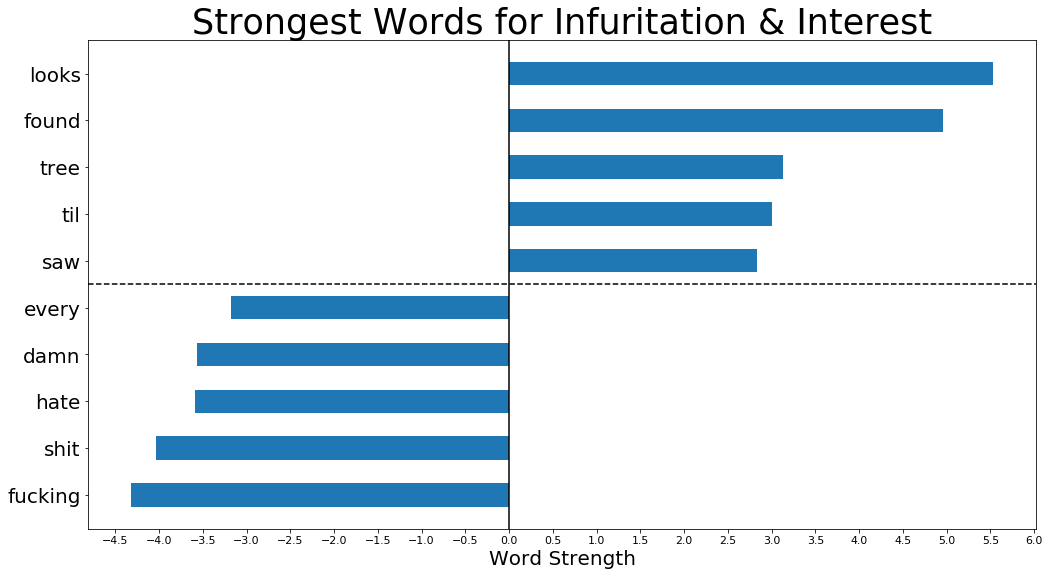

In [91]:
bar_plot_features(coef_df_2013, 2.82914, -3.126718, -4.5, 6.5, 4.5)

In [93]:
coef_df_2013.sort_values('Weight')['Feature'][:15]

266      fucking
612         shit
312         hate
181         damn
220        every
285      goddamn
41      annoying
758         want
58       asshole
604    seriously
509       people
786        worst
752       volume
218         even
696       thanks
Name: Feature, dtype: object

In [105]:
def same_diff(c1,c2):
    same,diff = [],[]
    same = list(set(c1.sort_values('Weight',ascending=False)['Feature'][:15]) & set(c2.sort_values('Weight',ascending=False)['Feature'][:15]))
    same += list(set(c1.sort_values('Weight')['Feature'][:15]) & set(c2.sort_values('Weight')['Feature'][:15]))
    diff = list(set(c1.sort_values('Weight',ascending=False)['Feature'][:15]) - set(c2.sort_values('Weight',ascending=False)['Feature'][:15]))
    diff += list(set(c1.sort_values('Weight')['Feature'][:15]) - set(c2.sort_values('Weight')['Feature'][:15]))
    return same,diff

In [106]:
same,diff = same_diff(coef_df_2013,coefs_df)

In [109]:
len(same), same

(13,
 ['found',
  'made',
  'face',
  'shaped',
  'looks',
  'tree',
  'annoying',
  'fucking',
  'hate',
  'shit',
  'every',
  'even',
  'thanks'])

In [110]:
len(diff), diff

(17,
 ['inside',
  'resembles',
  'egg',
  'saw',
  'formed',
  'perfectly',
  'grew',
  'landed',
  'til',
  'damn',
  'people',
  'asshole',
  'worst',
  'volume',
  'goddamn',
  'want',
  'seriously'])

**Out of the top 30 most impactful words from both 2013, and 2017, 13 overlap, and 17 are different. Even within that, it's clear that about half of the 17 different words are different forms of profanity, and about a quarter deals with nature and creation.**

# Task 4
(from [Notebook 0](jn_0_gather_data_and_eda.ipynb))

In [111]:
with open('../assets/lr_tuned_pipe.pkl', 'rb') as f:
    lr_2013 = pickle.load(f)

In [122]:
new_test = []
with open('../data/mildlyinteresting/2018/data_1535552658.json') as f:
    new_test += json.load(f)['data']
with open('../data/mildlyinfuriating/2018/data_1535506906.json') as f:
    new_test += json.load(f)['data']
    
df_test = pd.DataFrame(data=all_test, columns=['title','subreddit'])
df_test.drop_duplicates(inplace=True)

X_test_2018 = df_test['title']
y_test_2018 = pd.get_dummies(df_test['subreddit'],drop_first=True)

test_tf = tfidf.transform(X_test_2018)
test_tf.shape[0], y_test_2018.sum()/y_test_2018.shape[0]

(1988, mildlyinteresting    0.5
 dtype: float64)

(just checking if I have around 2000 posts and have balanced classes)

In [116]:
y_pred_2013 = lr_2013.predict(test_tf)

In [119]:
print('Accuracy Scores \n2013 Based: {} \n2017 Based: {}'.format(metrics.accuracy_score(y_test_2018.values.ravel(),y_pred_2013),
                                                                metrics.accuracy_score(y_test_2018.values.ravel(),y_pred)))

Accuracy Scores 
2013 Based: 0.5548289738430584 
2017 Based: 0.7012072434607646


Using some of the most recent subreddit posts, I can predict which subreddit a post belongs to with 70% accuracy using my model trained with 2017 data. That also informs me that, even though around 45% of the most impactful features remain the same from 2013 to 2017, the less impactful features are what play a part in distinguishing a subreddit. Not only that, I'm confident that if I trained data using posts from the first half of 2018, I would be able to better predict posts made later in 2018.